In [1]:
import string
import math
import numpy as np
import sympy
import sympy.physics.mechanics as me
import sys
from matplotlib.patches import Ellipse
from pylab import*
from pytope import Polytope
from scipy.spatial import ConvexHull
from __future__ import division

In [2]:
def traj(x0, u, omega, t):
    
    n_steps = len(t)
    dt = t[1]-t[0]

    # initial condition
    xs = x0
    out_xr = []
    
    tc = n_steps/(omega_t.shape[0]) # time of changing velocity
    
    for i in range(n_steps):
        
        # change of velocity
        if i % tc == 0:
            w = omega[int(i//tc)] #ut[int(i//tc*2)+1]
            if w == 0:
                v = u
            else:
                v = 1
        
        # store data
        out_xr.append(xs) # reference trajectory
        # Propagate reference
        xs = xs + dt*np.array([v*cos(xs[2]), v*sin(xs[2]), w])


    x = np.array(out_xr)
    return x

In [3]:
class MyConvexHull(object):
    
    def __init__(self, res=None, eqs=None, points=None, facets=None, max_dist=None):
        self.res = res
        self.eqs = eqs
        self.points = points
        self.facets = facets
        self.max_dist = max_dist

    @classmethod
    def from_points(cls, points, angle=0.99):
        res = pyhull.qconvex('n i A{:f} Fs'.format(angle), points)
        n_dim = int(res[0])-1
        n_eqs = int(res[1])
        eqs = array([line.split() for line in res[2:2+n_eqs]]).astype(float)
        n_facets = int(res[2+n_eqs])
        facets = array([line.split() for line in res[3+n_eqs:3+n_eqs+n_facets]]).astype(int)
        max_dist = float(res[4+n_eqs+n_facets].split()[1])
        return cls(res, eqs, points, facets, max_dist)
    
    @classmethod
    def from_halfspaces(cls, interior_point, halfspaces):
        s = 'H'
        for i in range(len(interior_point)):
            s += '{:5g},'.format(interior_point[i])
        opt = s + ' Fp'
        res = pyhull.qhull_cmd('qhalf', opt, halfspaces)
        n_dim = int(res[0])
        n_vert = int(res[1])
        points = array([line.split() for line in res[2:2+n_vert]]).astype(float)
        return cls.from_points(points)
    
    def add_buffer(self, b):
        self.eqs[:,-1] -= b
        s = zeros(self.points[0].shape)
        interior_point = self.points.mean(0)
        return MyConvexHull.from_halfspaces(interior_point, self.eqs)
    
    def __repr__(self):
        return string.join(self.res, '\n')
    
    def contains(self, p):
        return False

In [4]:
def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

In [5]:
def minBoundingRect(hull_points_2d):
    #print "Input convex hull points: "
    #print hull_points_2d

    # Compute edges (x2-x1,y2-y1)
    edges = zeros( (len(hull_points_2d)-1,2) ) # empty 2 column array
    for i in range( len(edges) ):
        edge_x = hull_points_2d[i+1,0] - hull_points_2d[i,0]
        edge_y = hull_points_2d[i+1,1] - hull_points_2d[i,1]
        edges[i] = [edge_x,edge_y]
    #print "Edges: \n", edges

    # Calculate edge angles   atan2(y/x)
    edge_angles = zeros( (len(edges)) ) # empty 1 column array
    for i in range( len(edge_angles) ):
        edge_angles[i] = math.atan2( edges[i,1], edges[i,0] )
    #print "Edge angles: \n", edge_angles

    # Check for angles in 1st quadrant
    for i in range( len(edge_angles) ):
        edge_angles[i] = abs( edge_angles[i] % (math.pi/2) ) # want strictly positive answers
    #print "Edge angles in 1st Quadrant: \n", edge_angles

    # Remove duplicate angles
    edge_angles = unique(edge_angles)
    #print "Unique edge angles: \n", edge_angles

    # Test each angle to find bounding box with smallest area
    min_bbox = (0, sys.maxsize, 0, 0, 0, 0, 0, 0) # rot_angle, area, width, height, min_x, max_x, min_y, max_y
    #print("Testing", len(edge_angles), "possible rotations for bounding box... \n")
    for i in range( len(edge_angles) ):

        # Create rotation matrix to shift points to baseline
        # R = [ cos(theta)      , cos(theta-PI/2)
        #       cos(theta+PI/2) , cos(theta)     ]
        R = array([ [ math.cos(edge_angles[i]), math.cos(edge_angles[i]-(math.pi/2)) ], [ math.cos(edge_angles[i]+(math.pi/2)), math.cos(edge_angles[i]) ] ])
        #print "Rotation matrix for ", edge_angles[i], " is \n", R

        # Apply this rotation to convex hull points
        rot_points = dot(R, transpose(hull_points_2d) ) # 2x2 * 2xn
        #print "Rotated hull points are \n", rot_points

        # Find min/max x,y points
        min_x = nanmin(rot_points[0], axis=0)
        max_x = nanmax(rot_points[0], axis=0)
        min_y = nanmin(rot_points[1], axis=0)
        max_y = nanmax(rot_points[1], axis=0)
        #print "Min x:", min_x, " Max x: ", max_x, "   Min y:", min_y, " Max y: ", max_y

        # Calculate height/width/area of this bounding rectangle
        width = max_x - min_x
        height = max_y - min_y
        area = width*height
        #print "Potential bounding box ", i, ":  width: ", width, " height: ", height, "  area: ", area 

        # Store the smallest rect found first (a simple convex hull might have 2 answers with same area)
        if (area < min_bbox[1]):
            min_bbox = ( edge_angles[i], area, width, height, min_x, max_x, min_y, max_y )
        # Bypass, return the last found rect
        #min_bbox = ( edge_angles[i], area, width, height, min_x, max_x, min_y, max_y )

    # Re-create rotation matrix for smallest rect
    angle = min_bbox[0]   
    R = array([ [ math.cos(angle), math.cos(angle-(math.pi/2)) ], [ math.cos(angle+(math.pi/2)), math.cos(angle) ] ])
    #print "Projection matrix: \n", R

    # Project convex hull points onto rotated frame
    proj_points = dot(R, transpose(hull_points_2d) ) # 2x2 * 2xn
    #print "Project hull points are \n", proj_points

    # min/max x,y points are against baseline
    min_x = min_bbox[4]
    max_x = min_bbox[5]
    min_y = min_bbox[6]
    max_y = min_bbox[7]
    #print "Min x:", min_x, " Max x: ", max_x, "   Min y:", min_y, " Max y: ", max_y

    # Calculate center point and project onto rotated frame
    center_x = (min_x + max_x)/2
    center_y = (min_y + max_y)/2
    center_point = dot( [ center_x, center_y ], R )
    #print "Bounding box center point: \n", center_point

    # Calculate corner points and project onto rotated frame
    corner_points = zeros( (4,2) ) # empty 2 column array
    corner_points[0] = dot( [ max_x, min_y ], R )
    corner_points[1] = dot( [ min_x, min_y ], R )
    corner_points[2] = dot( [ min_x, max_y ], R )
    corner_points[3] = dot( [ max_x, max_y ], R )
    #print "Bounding box corner points: \n", corner_points

    #print "Angle of rotation: ", angle, "rad  ", angle * (180/math.pi), "deg"

    return (angle, min_bbox[1], min_bbox[2], min_bbox[3], center_point, corner_points) # rot_angle, area, width, height, center_point, corner_points

In [6]:
link = lambda a,b: concatenate((a,b[1:]))
edge = lambda a,b: concatenate(([a],[b]))

def qhull2D(sample):
    def dome(sample,base): 
        h, t = base
        dists = dot(sample-h, dot(((0,-1),(1,0)),(t-h)))
        outer = repeat(sample, dists>0, 0)
        if len(outer):
            pivot = sample[argmax(dists)]
            return link(dome(outer, edge(h, pivot)),
                    dome(outer, edge(pivot, t)))
        else:
            return base
    if len(sample) > 2:
        axis = sample[:,0]
        base = take(sample, [argmin(axis), argmax(axis)], 0)
        return link(dome(sample, base), dome(sample, base[::-1]))
    else:
        return sample

In [7]:
def create_flow_tube(y, r, t):

    bound = r*ones(len(t)).reshape(len(t),1) # 1000*1
    #t, y, x = control.forced_response(sys, T=t, U=u, X0=x0)

    nom = y[:,0:2] # nominal trajecotry 1000*2
    
    #bounds
    p = array([
        nom + bound.dot(array([[1,1]])), 
        nom + bound.dot(array([[-1,1]])),
        nom + bound.dot(array([[1,-1]])),
        nom + bound.dot(array([[-1,-1]]))
    ])

    # space using arclength
    n_steps = 100
    arc_length = cumsum(norm(array([diff(nom[:,0]),diff(nom[:,1])]), axis=0))
    norm_arc_length = arc_length/arc_length[-1]
    i_steps = array([np.where(norm_arc_length >= per)[0] for per in linspace(0,1,n_steps)])

    # find convex sets
    flow_tube = []
    for i in range(n_steps-1):
        i0 = i_steps[i][0]
        i1 = i_steps[i+1][0]+1
        step = i1-i0
        p_i = reshape(p[:,i0:i1,:], [p.shape[0]*step,p.shape[2]])
        ch = MyConvexHull.from_points(p_i, angle=0.99)
        ch = ch.add_buffer(ch.max_dist)
        flow_tube.append(ch)
    return flow_tube, nom

In [8]:
def flowpipes(res, r, tf, n):
    
    t_vect = np.arange(0, tf, 0.1)
    
    y_vect = res['y']
    x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
    
    nom = array([x_r,y_r]).T
    
    # bound 
    theta_circ = np.linspace(0, 2*np.pi, 100)
    circ = array([r*np.cos(theta_circ), r*np.sin(theta_circ)]).T
    P2 = Polytope(circ) # invariant set
    
    flowpipes = []
    intervalhull = []
    steps = int(len(t_vect)/n)
    
    for i in range(n):
        # get traj for certain fixed time interval
        nom_i = nom[steps*i:steps*(i+1),:] # steps*2
        
        # Get interval hull
        hull_points = qhull2D(nom_i)
        # Reverse order of points, to match output from other qhull implementations
        hull_points = hull_points[::-1]
        (rot_angle, area, width, height, center_point, corner_points) = minBoundingRect(hull_points)
        
        # minkowski sum
        P1 = Polytope(corner_points) # interval hull
        P = P1+P2 # sum
        p1_vertices = P1.V
        p_vertices = P.V
        flowpipes.append(p_vertices)
        intervalhull.append(p1_vertices)
    return flowpipes, intervalhull, nom

In [27]:
#v = 5
#omega = pi/4
#x0 = np.array([0,0,0])
#ut = v
#omega_t = np.array([0,omega,0,omega,0,omega,0,omega])
#t = linspace(0,16,1600)
tf = 40
n = 20

HJB_s = 1.476 # HJB w/ control bound [-pi,pi]
HJB_l = 1.879
lyap_small = 1.4487 # lyapunov w/ small theta_max
lyap_large = 2.1136 # lyapunov w/ large theta_max


#xr = traj(x0, ut, omega_t, t)

flow_pipes_Ls, intervalhull_s, nom = flowpipes(res,lyap_small,tf, n)
flow_pipes_Ll, intervalhull_l, nom = flowpipes(res,lyap_large,tf, n)
flow_pipes_Hs, intervalhull_H, nom = flowpipes(res,HJB_s,tf, n)
flow_pipes_Hl, intervalhull_H, nom = flowpipes(res,HJB_l,tf, n)

In [34]:
flow_pipes_Ls[0].shape

(103, 2)

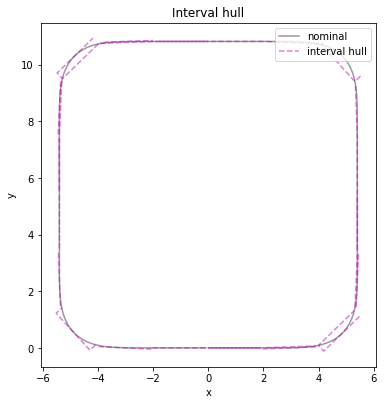

In [29]:
plt.figure(figsize=(9/1.5,9.5/1.5))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-', alpha = 0.4)
for facet in range(n):
    hs_ch_s = ax.plot(intervalhull_s[facet][:,0], intervalhull_s[facet][:,1], color='m', linestyle='--', alpha =0.5)
    #hs_ch_l = ax.plot(intervalhull_l[facet][:,0], intervalhull_l[facet][:,1], color='y', linestyle='--')


title('Interval hull')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_s[0]], ['nominal', 'interval hull'], loc=1);
#plt.xlim([-3, 13]);
#plt.ylim([-2, 15]);

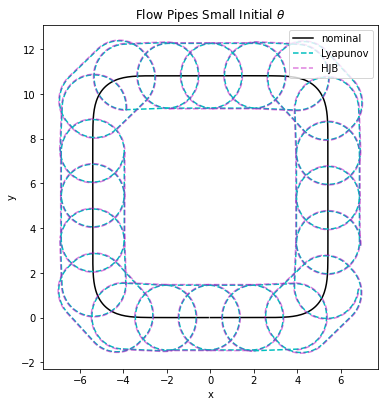

In [30]:
plt.figure(figsize=(9/1.5,9.5/1.5))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_Ls = ax.plot(flow_pipes_Ls[facet][:,0], flow_pipes_Ls[facet][:,1], color='c', linestyle='--')
    #hs_ch_Ll = ax.plot(flow_pipes_Ll[facet][:,0], flow_pipes_Ll[facet][:,1], color='y', linestyle='--')
    hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

title(r'Flow Pipes Small Initial $\theta$')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_Ls[0], hs_ch_Hs[0]], ['nominal', 'Lyapunov','HJB'], loc=1);
#plt.xlim([-5, 15]);
#plt.ylim([-4, 17]);

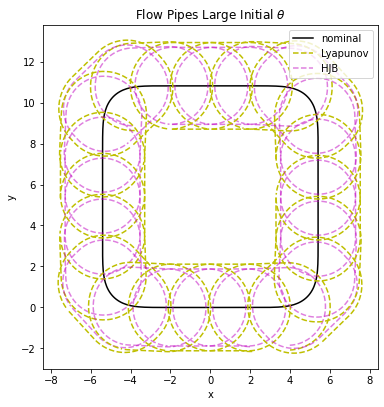

In [31]:
plt.figure(figsize=(9/1.5,9.5/1.5))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    #hs_ch_Ls = ax.plot(flow_pipes_Ls[facet][:,0], flow_pipes_Ls[facet][:,1], color='c', linestyle='--')
    hs_ch_Ll = ax.plot(flow_pipes_Ll[facet][:,0], flow_pipes_Ll[facet][:,1], color='y', linestyle='--')
    hs_ch_Hl = ax.plot(flow_pipes_Hl[facet][:,0], flow_pipes_Hl[facet][:,1], color='m', linestyle='--', alpha = 0.5)

title(r'Flow Pipes Large Initial $\theta$')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_Ll[0], hs_ch_Hl[0]], ['nominal', 'Lyapunov','HJB'], loc=1);

In [14]:
import control
import slycot

def solve_control_gain():
    A = -se2(x=1, y=0, theta=0).ad_matrix
    B = np.array([[1, 0], [0, 0], [0, 1]])
    Q = 10*np.eye(3)  # penalize state
    R = 1*np.eye(2)  # penalize input
    K, _, _ = control.lqr(A, B, Q, R)
    K = -K  # rescale K, set negative feedback sign
    return K, B

K, B = solve_control_gain()
K, B

(array([[-3.16227766, -0.        , -0.        ],
        [-0.        , -3.16227766, -4.04036574]]),
 array([[1, 0],
        [0, 0],
        [0, 1]]))

In [15]:
def control_law(B, K, e):
    L = np.diag(np.array([1, 0, 1]))
    u = L@se2_diff_correction_inv(e)@B@K@e.vee
    return se2.from_vector(u)

In [16]:
def dynamics(t, y_vect, freq_d, w_mag, use_approx):
    X = SE2(x=y_vect[0], y=y_vect[1], theta=y_vect[2])
    X_r = SE2(x=y_vect[3], y=y_vect[4], theta=y_vect[5])
    
    e = se2(x=y_vect[6], y=y_vect[7], theta=y_vect[8])
    eta = X.inv@X_r
    e_nl = eta.log
    
    # reference input
    v_r = se2(x=1, y=0, theta=4*np.pi/1155*(1 - np.cos(2*np.pi*t/10))**6)
    
    # disturbance
    w = w_mag*se2(x=np.sin(2*np.pi*freq_d*t), y=np.sin(2*np.pi*freq_d*t), theta=np.sin(2*np.pi*freq_d*t))
    
    # control law applied to non-linear error
    u_nl = control_law(B, K, e_nl)
    v_nl = v_r + u_nl + w
    
    # control law applied to log-linear error
    u = control_law(B, K, e)
    v = v_r + u + w
        
    # log error dynamics
    U = se2_diff_correction(e)
    if use_approx:
        # these dynamics don't hold exactly unless you can move sideways
        e_dot = se2.from_vector((-v_r.ad_matrix + B@K)@e.vee + U@w.vee)
    else:
        # these dynamics, always hold
        e_dot = -v_r@e + se2.from_vector(U@(u + w).vee)
    
    return [
        # actual
        v_nl.x*np.cos(X.theta) - v_nl.y*np.sin(X.theta),
        v_nl.x*np.sin(X.theta) + v_nl.y*np.cos(X.theta),
        v_nl.theta,
        # reference
        v_r.x*np.cos(X_r.theta) - v_r.y*np.sin(X_r.theta),
        v_r.x*np.sin(X_r.theta) + v_r.y*np.cos(X_r.theta),
        v_r.theta,
        # log error
        e_dot.x,
        e_dot.y,
        e_dot.theta
    ]

In [17]:
import scipy.integrate
import os
import matplotlib.pyplot as plt

def simulate(tf, freq_d, w_mag, x0, y0, theta0, use_approx):
    t_vect = np.arange(0, tf, 0.1)  # time vector

    X0 = SE2(x=x0, y=y0, theta=theta0)  # initial state
    X0_r = SE2(x=0, y=0, theta=0)  # initial reference state
    x0 = (X0.inv@X0_r).log  # initial log of error

    # solve initial value problem
    res = scipy.integrate.solve_ivp(
        fun=dynamics,
        t_span=[t_vect[0], t_vect[-1]], t_eval=t_vect,
        y0=[X0.x, X0.y, X0.theta,
            X0_r.x, X0_r.y, X0_r.theta,
            x0.x, x0.y, x0.theta], args=[freq_d, w_mag, use_approx], rtol=1e-12, atol=1e-3)
    return res

def plot_simulated(res, name=None, legend=False, save=False):
    if save:
        os.makedirs('figures', exist_ok=True)
        
    y_vect = res['y']
    x, y, theta, x_r, y_r, theta_r, log_e_x, log_e_y, log_e_theta = [y_vect[i, :] for i in range(len(y_vect))]
    ref = array([x,y])

    plt.rcParams['figure.figsize'] = (15, 10)
    
    plt.figure(1)
    title = name + 'X-Y Trajectory'
    plt.title(title)
    plt.grid(True)
    plt.plot(x, y, 'b-', linewidth=3, alpha=0.5)
    plt.plot(x_r, y_r, 'y-', alpha=1, linewidth=3, label='Reference' if legend else None)
    plt.xlabel('x, m')
    plt.ylabel('y, m')
    
    if legend:
        plt.legend()
    plt.axis('equal');
    if save:
        plt.savefig('figures/' + title)

NameError: name 'n' is not defined

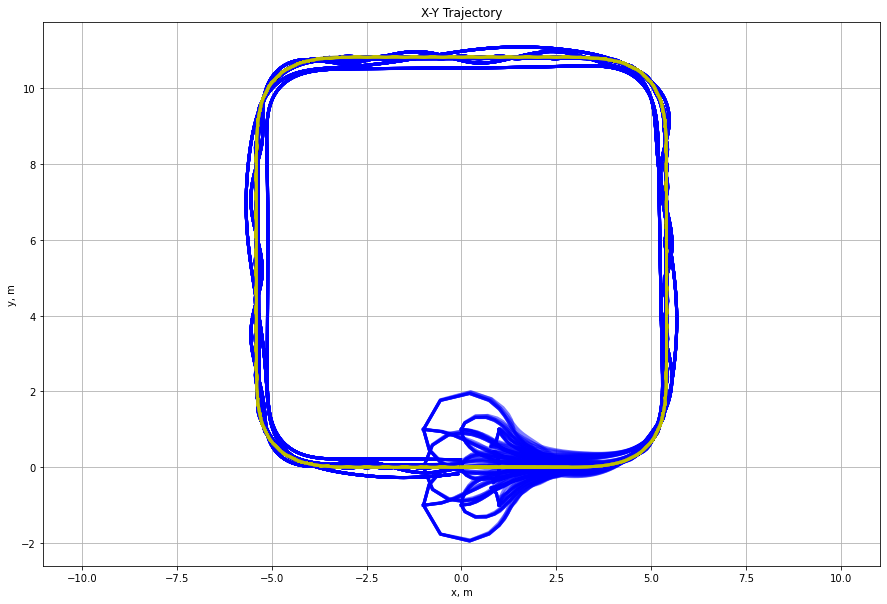

In [18]:
freq = [0, 0.001, 0.01, 0.1, 0.28, 1, 2]
res = []
for i in freq:
    for theta0 in np.linspace(-pi/2, pi/2, 3):
        for x0 in np.linspace(-1, 1, 3):
            for y0 in np.linspace(-1, 1, 3):
                r = simulate(40, i, 0.2, x0, y0, theta0, use_approx=False)
                plot_simulated(r, name='', legend=False, save=False)
                res.append(r)
for facet in range(n):
    hs_ch_Ll = plt.plot(flow_pipes_Ll[facet][:,0], flow_pipes_Ll[facet][:,1], color='c', linestyle='--')
    hs_ch_Hl = plt.plot(flow_pipes_Hl[facet][:,0], flow_pipes_Hl[facet][:,1], color='m', linestyle='--', alpha = 0.5)

h_nom = ax.plot(nom[:,0], nom[:,1], 'y-', alpha=1, linewidth=3)
    
title(r'Flow Pipes Large Initial $\theta$')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_Ll[0], hs_ch_Hl[0]], ['nominal', 'Lyapunov','HJB'], loc=1);

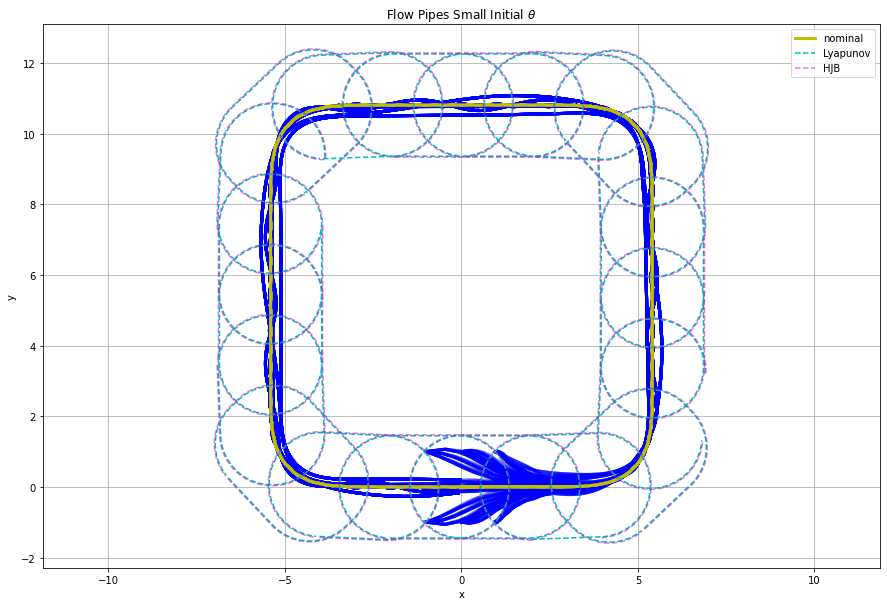

In [80]:
freq = [0, 0.001, 0.01, 0.1, 0.28, 1, 2]
res = []
for i in freq:
     for theta0 in np.linspace(-pi/10, pi/10, 3):
        for x0 in np.linspace(-1, 1, 3):
            for y0 in np.linspace(-1, 1, 3):
                r = simulate(40, i, 0.2, x0, y0, theta0, use_approx=False)
                plot_simulated(r, name='', legend=False, save=False)
                res.append(r)
for facet in range(n):
    hs_ch_Ls = plt.plot(flow_pipes_Ls[facet][:,0], flow_pipes_Ls[facet][:,1], color='c', linestyle='--')
    hs_ch_Hs = plt.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)
h_nom = ax.plot(nom[:,0], nom[:,1], 'y-', alpha=1, linewidth=3)

title(r'Flow Pipes Small Initial $\theta$')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_Ls[0], hs_ch_Hs[0]], ['nominal', 'Lyapunov','HJB'], loc=1);

In [13]:
import math
import numpy as np


def matrix_exp(A, n=30):
    s = np.zeros((3, 3))
    A_i = np.eye(3)
    for i in range(n):
        s = s + A_i/math.factorial(i)
        A_i = A_i@A
    return s


def check_shape(a, shape):
    if np.shape(a) != shape:
        raise IOError(str(np.shape(a)) + '!=' + str(shape))


def wrap(x):
    return np.where(np.abs(x) >= np.pi, (x + np.pi) % (2 * np.pi) - np.pi, x)


class LieGroup:
    
    def __repr__(self):
        return repr(self.matrix)

    def __mul__(self, other):
        return NotImplementedError('')

    
class LieAlgebra:
    
    def __repr__(self):
        return repr(self.wedge)

    def __mul__(self, other):
        return NotImplementedError('')


class Vector:
    
    def __repr__(self):
        return repr(self.matrix)

    def __mul__(self, other):
        return NotImplementedError('')


class R2(Vector):
    
    def __init__(self, x, y):
        self.x = float(x)
        self.y = float(y)
    
    @property
    def matrix(self):
        return np.array([[self.x], [self.y]])

    def __neg__(self):
        return R2(x=-self.x, y=-self.y)
    
    def __add__(self, other):
        return R2(x=self.x + other.x, y=self.y + other.y)

    @classmethod
    def from_vector(cls, a):
        a = a.reshape(-1)
        return cls(x=a[0], y=a[1])

    
class so2(LieAlgebra):
    
    def __init__(self, theta):
        self.theta = np.reshape(wrap(theta), ())
    
    @property
    def wedge(self):
        return np.array([
            [0, -self.theta],
            [self.theta, 0]
        ])
    
    @property
    def vee(self):
        return np.array([self.theta])

    @property
    def exp(self):
        return SO2(theta=self.theta)
    

class SO2(LieGroup):
    
    def __init__(self, theta):
        self.theta = np.reshape(wrap(theta), ())
    
    @classmethod
    def one(cls):
        return cls(theta=0)

    @property
    def inv(self):
        return SO2(theta=-self.theta)

    @property
    def matrix(self):
        return np.array([
            [np.cos(self.theta), -np.sin(self.theta)],
            [np.sin(self.theta), np.cos(self.theta)]
        ])
    
    @property
    def params(self):
        return np.array([self.theta])

    @property
    def log(self):
        return so2(self.theta)
    
    @classmethod
    def from_matrix(cls, a):
        check_shape(a, (2, 2))
        return cls(theta=np.arctan2(a[1, 0], a[0, 0]))

    def __matmul__(self, other):
        if isinstance(other, R2):
            return R2.from_vector(self.matrix@other.matrix)
        elif isinstance(other, SO2):
            return SO2(theta=self.theta + other.theta)


class se2(LieAlgebra):
    
    def __init__(self, x: float, y: float, theta: float):
        self.x = float(x)
        self.y = float(y)
        self.theta = float(theta)

    def __neg__(self):
        return se2(-self.x, -self.y, -self.theta)

    @property
    def wedge(self):
        return np.array([
            [0, -self.theta, self.x],
            [self.theta, 0, self.y],
            [0, 0, 0]
        ])
    

    def __add__(self, other):
        return se2(x=self.x + other.x, y=self.y + other.y, theta=self.theta + other.theta)
    
    def __sub__(self, other):
        return se2(x=self.x - other.x, y=self.y - other.y, theta=self.theta - other.theta)
    
    @property
    def vee(self):
        return np.array([self.x, self.y, self.theta])
    
    @classmethod
    def from_vector(cls, a):
        a = a.reshape((3, 1))
        return cls(x=a[0], y=a[1], theta=a[2])
    
    @classmethod
    def from_matrix(cls, a):
        check_shape(a, (3, 3))
        return cls(x=a[0, 2], y=a[1, 2], theta=a[1, 0])

    @property
    def ad_matrix(self):
        x, y, theta = self.x, self.y, self.theta
        return np.array([
            [0, -theta, y],
            [theta, 0, -x],
            [0, 0, 0]
        ])

    def __matmul__(self, other):
        return se2.from_vector(self.ad_matrix@other.vee)

    @property
    def exp(self):
        theta = self.theta
        with np.errstate(divide='ignore',invalid='ignore'):
            a = np.where(np.abs(theta) < 1e-3, 1 - theta**2/6 + theta**4/12, np.sin(theta)/theta)
            b = np.where(np.abs(theta) < 1e-3, theta/2 - theta**3/24 + theta**5/720, (1 - np.cos(theta))/theta)
        V = np.array([[a, -b], [b, a]])
        p = V@np.array([self.x, self.y])
        return SE2(x=p[0], y=p[1], theta=self.theta)

    def __rmul__(self, scalar):
        s = np.reshape(scalar, ())
        return se2(x=self.x*s, y=self.y*s, theta=self.theta*s)


class SE2(LieGroup):
    
    def __init__(self, x: float, y: float, theta: float):
        self.x = float(x)
        self.y = float(y)
        self.theta = wrap(float(theta))
    
    @classmethod
    def one(cls):
        return cls(x=0, y=0, theta=0)

    @property
    def params(self):
        return np.array([self.x, self.y, self.theta])
    
    @property
    def matrix(self):
        x, y, theta = self.x, self.y, self.theta
        return np.array([
            [np.cos(theta), -np.sin(theta), x],
            [np.sin(theta), np.cos(theta), y],
            [0, 0, 1]
        ])

    @property
    def R(self):
        return SO2(theta=self.theta)

    @property
    def p(self):
        return R2(x=self.x, y=self.y)
    
    @property
    def inv(self):
        p = -(self.R.inv@self.p)
        return SE2(x=p.x, y=p.y, theta=-self.theta)

    def __matmul__(self, other: 'SE2'):
        p = self.R@other.p + self.p
        return SE2(x=p.x, y=p.y, theta=self.theta + other.theta)

    @classmethod
    def from_matrix(cls, a: np.array):
        check_shape(a, (3, 3))
        return SE2(theta=np.arctan2(a[1, 0], a[0, 0]),
                   x=a[0, 2], y=a[1, 2])
    
    @classmethod
    def from_vector(cls, a):
        a = a.reshape((3, 1))
        return cls(x=a[0], y=a[1], theta=a[2])

    @property
    def Ad_matrix(self):
        x, y, theta = self.x, self.y, self.theta
        return np.array([
            [np.cos(theta), -np.sin(theta), y],
            [np.sin(theta), np.cos(theta), -x],
            [0, 0, 1]
        ])
    
    def Ad(self, v: 'se2'):
        v2 = self.Ad_matrix@v.vee
        return se2(x=v2[0], y=v2[1], theta=v2[2])

    @property
    def log(self):
        x, y, theta = self.x, self.y, self.theta
        with np.errstate(divide='ignore',invalid='ignore'):
            a = np.where(np.abs(theta) < 1e-3, 1 - theta**2/6 + theta**4/12, np.sin(theta)/theta)
            b = np.where(np.abs(theta) < 1e-3, theta/2 - theta**3/24 + theta**5/720, (1 - np.cos(theta))/theta)
        V_inv = np.array([
            [a, b],
            [-b, a]
        ])/(a**2 + b**2)
        p = V_inv@np.array([x, y])
        return se2(x=p[0], y=p[1], theta=theta)     

In [12]:
def diff_correction(e: se2, n=100):
    # computes (1 - exp(-ad_x)/ad_x = sum k=0^infty (-1)^k/(k+1)! (ad_x)^k
    ad = e.ad_matrix
    ad_i = np.eye(3)
    s = np.zeros((3, 3))
    for k in range(n):
        s += ((-1)**k/math.factorial(k+1))*ad_i
        ad_i = ad_i @ ad
    return -np.linalg.inv(s)@((-e).exp.Ad_matrix)

def se2_diff_correction(e: se2):
    x = e.x
    y = e.y
    theta = e.theta
    with np.errstate(divide='ignore',invalid='ignore'):
        a = np.where(abs(theta) > 1e-3, -theta*np.sin(theta)/(2*(np.cos(theta) - 1)), 1 - theta**2/12 - theta**4/720)
        b = np.where(abs(theta) > 1e-3, -(theta*x*np.sin(theta) + (1 - np.cos(theta))*(theta*y - 2*x))/(2*theta*(1 - np.cos(theta))), -y/2 + theta*x/12 - theta**3*x/720)
        c = np.where(abs(theta) > 1e-3, -(theta*y*np.sin(theta) + (1 - np.cos(theta))*(-theta*x - 2*y))/(2*theta*(1 - np.cos(theta))), x/2 + theta*y/12 + theta**3*y/720)
    return -np.array([
        [a, theta/2, b],
        [-theta/2, a, c],
        [0, 0, 1]
    ])

def se2_diff_correction_inv(e: se2):
    x = e.x
    y = e.y
    theta = e.theta
    with np.errstate(divide='ignore',invalid='ignore'):
        a = np.where(abs(theta) > 1e-3, np.sin(theta)/theta, 1 - theta**2/6 + theta**4/120)
        b = np.where(abs(theta) > 1e-3, (1  - np.cos(theta))/theta, theta/2 - theta**3/24)
        c = np.where(abs(theta) > 1e-3, -(x*(theta*np.cos(theta) - theta + np.sin(theta) - np.sin(2*theta)/2) + y*(2*np.cos(theta) - np.cos(2*theta)/2 - 3/2))/(theta**2*(1 - np.cos(theta))), y/2 + theta*x/6 - theta**2*y/24 - theta**3*x/120 + theta**4*y/720)
        d = np.where(abs(theta) > 1e-3, -(x*(-2*np.cos(theta) + np.cos(2*theta)/2 + 3/2) + y*(theta*np.cos(theta) - theta + np.sin(theta) - np.sin(2*theta)/2))/(theta**2*(1 - np.cos(theta))), -x/2 + theta*y/6 + theta**2*x/24 - theta**3*y/120 - theta**4*x/720)
    return -np.array([
        [a, -b, c],
        [b, a, d],
        [0, 0, 1]
    ])

v = se2(0.1, 0.2, 0.3)
diff_correction(v), se2_diff_correction(v)

(array([[-0.99248873, -0.15      ,  0.09749624],
        [ 0.15      , -0.99248873, -0.05500752],
        [ 0.        ,  0.        , -1.        ]]),
 array([[-0.99248873, -0.15      ,  0.09749624],
        [ 0.15      , -0.99248873, -0.05500752],
        [-0.        , -0.        , -1.        ]]))